# Galería de modelo prueba para aplicación Deep Leaves
Creación y comparación de modelos para clasificar un dataset de imágenes de hojas de plantas 

## Librerias

In [1]:
# Librerías de manipulación de datos y visualización
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageFile
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import joblib

# Librerías de Sklearn
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import v2 as transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

from torch.utils.data import DataLoader, random_split

## Rutas
Rutas que se usan de manera transversal en el código 

In [2]:
# paths
path="Data/"
path_pruebas="Prueba/"
modelo_resnet50 = "Modelos/resnet50.pth"
modelo_cnn_ruta = "Modelos/cnn_gpu.pth"
modelo_cnn_ruta_best = "Modelos/cnn_gpu_best.pth"
modelo_mobilenet_ruta = "Modelos/modelo_entrenado_mobilenetv1_norm.pth"
modelo_mobilenet_ruta_best = "Modelos/modelo_entrenado_mobilenetv1_norm_best.pth"
modelo_mobilenetv2_ruta = "Modelos/modelo_entrenado_mobilenetv2_norm.pth"
modelo_mobilenetv2_ruta_best = "Modelos/modelo_entrenado_mobilenetv2_norm_best.pth"
model_randomforest_save_path = 'Modelos/modelo_randomforest.pkl'

In [3]:

modelo_resnet50_best  = "Modelos/resnet50_best.pth"
modelo_resnet50_best2  = "Modelos/resnet50_best2.pth"
modelo_resnet50_80 = "CopiR50/resnet50_82.pth"

In [1]:
!pip freeze > requirements.txt

## Lectura y limpieza
Se dividen los datos en Train (Entrenamiento) y Val (Validación) de manera aleatoria en una división de 70% para entrenamiento donde los datos pueden ser alterados con rotaciones, cambios de color y al final se normalizan (Se dejan con un intervalo de colores); 30% para validación sin alterar

In [4]:

# Definir transformaciones de datos para el conjunto de entrenamiento y validación
transform_train = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomRotation(35),
    transforms.RandomResizedCrop(224, antialias=True), 
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.305, 0.305, 0.305], std=[0.3, 0.3, 0.3]),
])
# Definir transformaciones para el conjunto de validación y prueba (sin aumentar datos)
val_test_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(256, antialias=True),             # Redimensionar a 256x256
    transforms.CenterCrop(224),         # Recortar al centro 224x224
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización
])
# Directorio de datos
data_directory = os.path.join(path)

# Aplicar transformaciones a los conjuntos de datos
train_dataset = torchvision.datasets.ImageFolder(root=data_directory, transform=transform_train)
val_dataset = torchvision.datasets.ImageFolder(root=data_directory, transform=val_test_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=data_directory, transform=val_test_transforms)

# Obtener el tamaño total del conjunto de datos
total_size = len(train_dataset)

# Calcular los tamaños de los conjuntos de entrenamiento, validación y prueba
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Obtener los índices para cada conjunto
train_indices, temp_indices = random_split(range(total_size), [train_size, total_size - train_size])
val_indices, test_indices = random_split(temp_indices.indices, [val_size, test_size])

# Crear Subset para cada conjunto
train_data = torch.utils.data.Subset(train_dataset, train_indices)
val_data = torch.utils.data.Subset(val_dataset, val_indices)
test_data = torch.utils.data.Subset(test_dataset, test_indices)

# Crear DataLoader para el conjunto de entrenamiento
train_loader = DataLoader(train_data, batch_size=36, shuffle=True)

# Crear DataLoader para el conjunto de validación
val_loader = DataLoader(val_data, batch_size=36, shuffle=False)

# Crear DataLoader para el conjunto de prueba
test_loader = DataLoader(test_data, batch_size=36, shuffle=False)

# Obtener el número total de muestras de entrenamiento, validación y prueba
num_train_samples = len(train_data)
num_validation_samples = len(val_data)
num_test_samples = len(test_data)

# Imprimir los datos totales
print("Total de muestras de entrenamiento:", num_train_samples)
print("Total de muestras de validación:", num_validation_samples)
print("Total de muestras de prueba:", num_test_samples)

# Obtener las clases originales a partir de los nombres de las carpetas
#class_names = augmented_dataset.classes

# Obtener las clases originales a partir de los nombres de las carpetas
class_names = train_dataset.classes

num_classes = len(train_dataset.classes)

print("Total de clases:", num_classes)

Total de muestras de entrenamiento: 39898
Total de muestras de validación: 4987
Total de muestras de prueba: 4988
Total de clases: 5


In [5]:
# Pruebas de 100 imagenes poco ideales
from PIL import Image

transform_test2 = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((224, 224)),  # Redimensionar todas las imágenes a 224x224 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.305, 0.305, 0.305], std=[0.3, 0.3, 0.3]),
])

# Directorio de datos
data_directoryP = os.path.join(path_pruebas)

# Crear el conjunto de datos utilizando ImageFolder
datasetP = torchvision.datasets.ImageFolder(
    root=data_directoryP,
    transform=transform_test2
)

test_loader2 = DataLoader(datasetP,batch_size=10, shuffle=False)

### Verificar

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

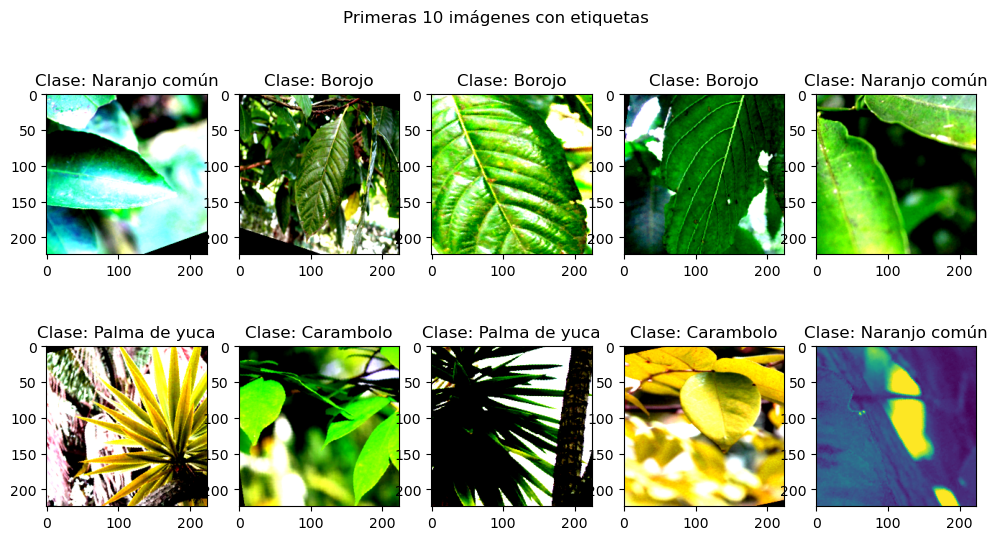

In [6]:
# Obtener un lote de datos de entrenamiento
for batch_images, batch_labels in train_loader:
   break

# Visualizar las primeras 10 imágenes con sus etiquetas
num_images_to_show = 10

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Primeras 10 imágenes con etiquetas')

for i in range(num_images_to_show):
   image = batch_images[i].permute(1, 2, 0).numpy() # Cambiar dimensiones para visualización
   label = int(batch_labels[i].item())

   axes[i // 5, i % 5].imshow(image)
   axes[i // 5, i % 5].set_title(f'Clase: {class_names[label]}')

for channel in range(3):
    axes[i // 5, i % 5].imshow(image[:, :, channel])

plt.show()

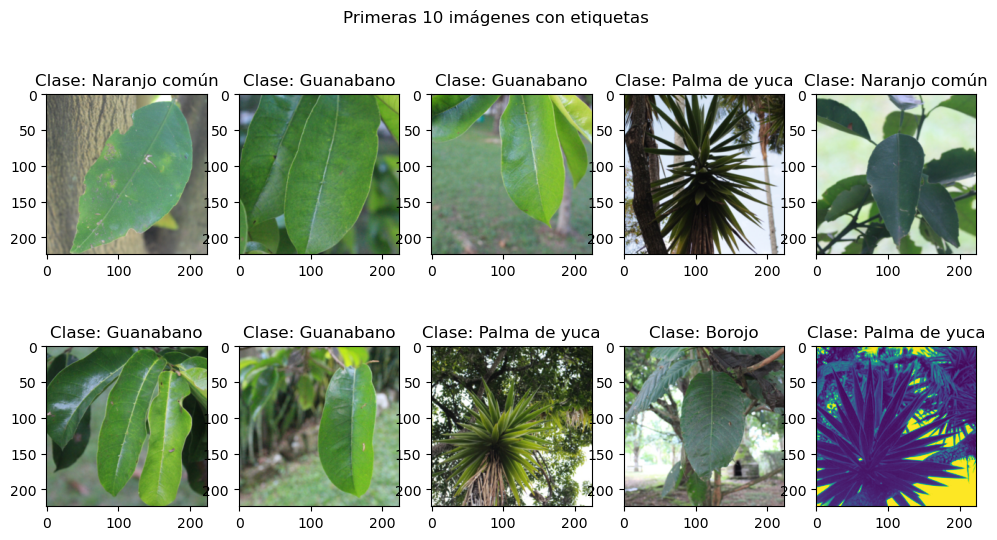

In [7]:
# Obtener un lote de datos de VAL
for batch_images, batch_labels in val_loader:
   break

# Visualizar las primeras 10 imágenes con sus etiquetas
num_images_to_show = 10

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Primeras 10 imágenes con etiquetas')

for i in range(num_images_to_show):
   image = batch_images[i].permute(1, 2, 0).numpy() # Cambiar dimensiones para visualización
   label = int(batch_labels[i].item())

   axes[i // 5, i % 5].imshow(image)
   axes[i // 5, i % 5].set_title(f'Clase: {class_names[label]}')

for channel in range(3):
    axes[i // 5, i % 5].imshow(image[:, :, channel])

plt.show()

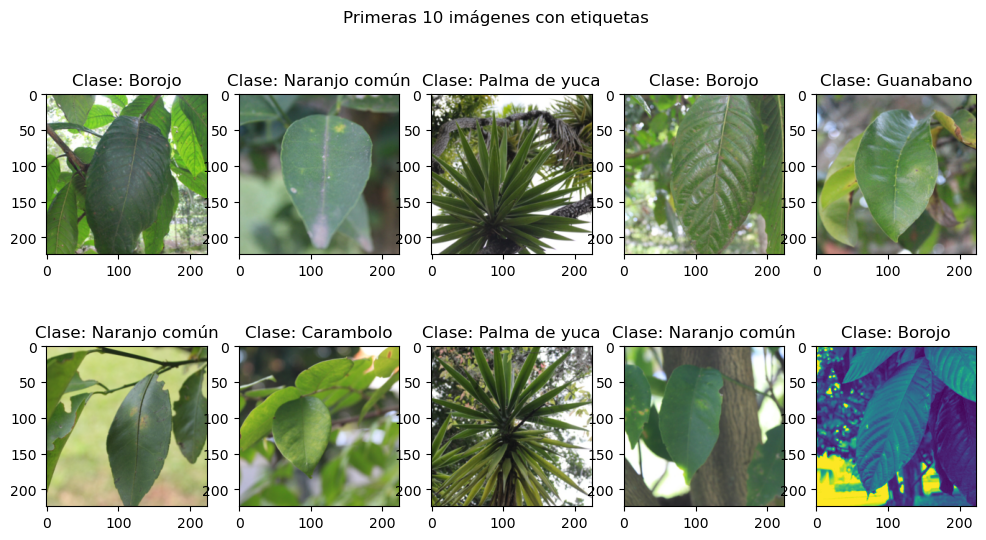

In [8]:
# Obtener un lote de datos de test
for batch_images, batch_labels in test_loader:
   break

# Visualizar las primeras 10 imágenes con sus etiquetas
num_images_to_show = 10

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Primeras 10 imágenes con etiquetas')

for i in range(num_images_to_show):
   image = batch_images[i].permute(1, 2, 0).numpy() # Cambiar dimensiones para visualización
   label = int(batch_labels[i].item())

   axes[i // 5, i % 5].imshow(image)
   axes[i // 5, i % 5].set_title(f'Clase: {class_names[label]}')

for channel in range(3):
    axes[i // 5, i % 5].imshow(image[:, :, channel])

plt.show()

C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for

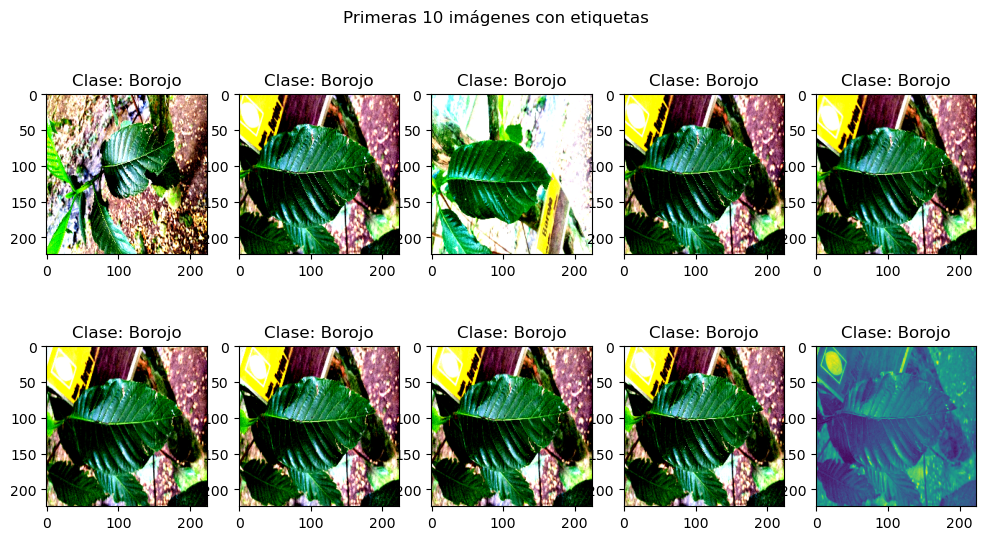

In [9]:
# Obtener un lote de datos de test 2
for batch_images, batch_labels in test_loader2:
   break

# Visualizar las primeras 10 imágenes con sus etiquetas
num_images_to_show = 10

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Primeras 10 imágenes con etiquetas')

for i in range(num_images_to_show):
   image = batch_images[i].permute(1, 2, 0).numpy() # Cambiar dimensiones para visualización
   label = int(batch_labels[i].item())

   axes[i // 5, i % 5].imshow(image)
   axes[i // 5, i % 5].set_title(f'Clase: {class_names[label]}')

for channel in range(3):
    axes[i // 5, i % 5].imshow(image[:, :, channel])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


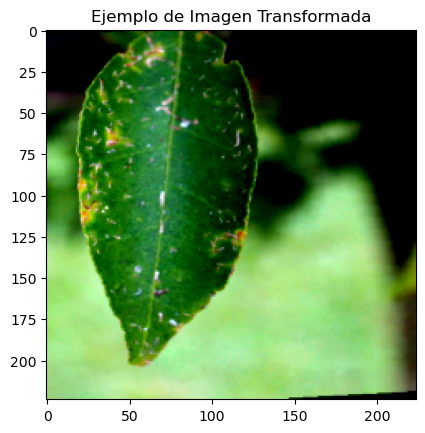

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


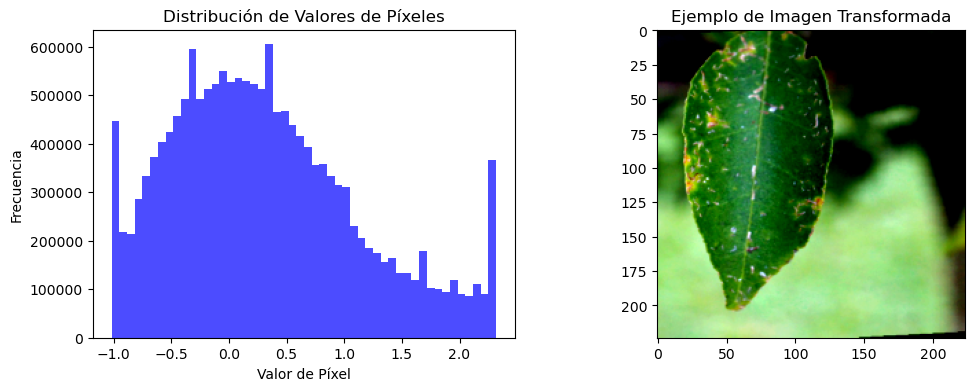

In [10]:
# Función para obtener los datos después de aplicar las transformaciones
def get_transformed_data(loader, num_samples=100):
    data_samples = []
    for i, (images, _) in enumerate(loader):
        if i * len(images) >= num_samples:
            break
        data_samples.append(images)
    return torch.cat(data_samples, dim=0)

# Obtener datos transformados de tu conjunto de entrenamiento
transformed_data = get_transformed_data(train_loader)

# Visualizar la distribución de los valores de píxeles en una imagen de muestra
sample_image = transformed_data[5].permute(1, 2, 0).numpy()
plt.imshow(sample_image)
plt.title('Ejemplo de Imagen Transformada')
plt.show()

# Visualizar la distribución de valores de píxeles en todas las imágenes
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(transformed_data.numpy().flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Distribución de Valores de Píxeles')
plt.xlabel('Valor de Píxel')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.imshow(transformed_data[5].permute(1, 2, 0).numpy())
plt.title('Ejemplo de Imagen Transformada')
plt.show()

In [10]:
#Verificar
print(class_names)
print(num_classes)
print(num_train_samples)
print(num_validation_samples)

['Borojo', 'Carambolo', 'Guanabano', 'Naranjo común', 'Palma de yuca']
5
39898
4987


# Resnet50 Finetunnig
ResNet50 es un modelo de red neuronal convolucional profunda desarrollado por Kaiming He, Xiangyu Zhang, Shaoqing Ren y Jian Sun. El código del modelo está disponible bajo la licencia Apache 2.0.
ResNet50 consta de 50 capas convolucionales, organizadas en 4 bloques de 3 capas cada uno. Cada bloque consta de una serie de capas convolucionales seguidas de una capa de normalización de activación (ReLU) y una capa de suma residual. La capa de suma residual permite que el modelo aprenda dependencias entre capas, lo que ayuda a evitar el sobreajuste y a mejorar el rendimiento.

In [7]:
# Definir el modelo
# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions, Actual accuracy 80.858%
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Modificar la capa de salida para adaptarla a 5 clases
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # 5 clases en tu conjunto de datos

# Verificar la estructura del modelo modificado
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Entrenamiento 

In [8]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Número de épocas (iteraciones completas sobre el conjunto de datos)
num_epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mover el modelo a la GPU si está disponible
model.to(device)

# Entrenamiento y evaluación del modelo
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validar el modelo
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy}')

# Guardar el modelo entrenado
torch.save(model.state_dict(), modelo_resnet50_rl)

print('Entrenamiento completado.')

Epoch 1/5, Validation Accuracy: 1.0
Epoch 2/5, Validation Accuracy: 1.0
Epoch 3/5, Validation Accuracy: 1.0
Epoch 4/5, Validation Accuracy: 1.0
Epoch 5/5, Validation Accuracy: 1.0
Entrenamiento completado.


In [26]:
# 10 Epochs mas con norm
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo_r50.parameters(), lr=0.001)

# Número de épocas (iteraciones completas sobre el conjunto de datos)
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mover el modelo a la GPU si está disponible
modelo_r50.to(device)

# Entrenamiento y evaluación del modelo
for epoch in range(num_epochs):
    modelo_r50.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = modelo_r50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validar el modelo
    modelo_r50.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo_r50(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy}')

# Guardar el modelo entrenado
torch.save(modelo_r50.state_dict(), modelo_resnet50_rl2)

print('Entrenamiento completado.')

Epoch 1/10, Validation Accuracy: 0.994986966111891
Epoch 2/10, Validation Accuracy: 0.9995989572889513
Epoch 3/10, Validation Accuracy: 0.9320232604772408
Epoch 4/10, Validation Accuracy: 1.0
Epoch 5/10, Validation Accuracy: 0.9951874874674153
Epoch 6/10, Validation Accuracy: 1.0
Epoch 7/10, Validation Accuracy: 0.9995989572889513
Epoch 8/10, Validation Accuracy: 0.9997994786444756
Epoch 9/10, Validation Accuracy: 0.9997994786444756
Epoch 10/10, Validation Accuracy: 0.9995989572889513
Entrenamiento completado.


## Control overfit

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_r50 = resnet50(weights=None)

# Modificar la capa de salida para adaptarla a 5 clases
num_ftrs = modelo_r50.fc.in_features
modelo_r50.fc = nn.Linear(num_ftrs, 5)  # 5 clases en tu conjunto de datos

# Cargar los pesos guardados en el modelo
modelo_r50.load_state_dict(torch.load(modelo_resnet50_best))
modelo_r50 = modelo_r50.to(device)
modelo_r50.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, path=modelo_resnet50_best2):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

modelo = modelo_r50.to(device)  # Mover el modelo al dispositivo
optimizer = optim.Adam(modelo.parameters(), lr=0.0001, weight_decay=1e-5)  # Optimizador
criterion = nn.CrossEntropyLoss()  # Criterio de pérdida

# Inicializar EarlyStopping
early_stopping = EarlyStopping(patience=5, verbose=True)
num_epochs = 20

for epoch in range(num_epochs):
    modelo.train()  # Modo de entrenamiento
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Moviendo los datos al dispositivo
        optimizer.zero_grad()
        outputs = modelo(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validación del modelo
    modelo.eval()  # Modo de evaluación
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Moviendo los datos al dispositivo
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs, 1)
            val_loss += criterion(outputs, labels).item()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    early_stopping(val_loss, modelo)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Cargar el mejor modelo guardado
modelo.load_state_dict(torch.load(modelo_resnet50))

Epoch 1/20, Validation Loss: 1.7222, Validation Accuracy: 0.7768
Validation loss decreased (inf --> 1.722200).  Saving model ...
Epoch 2/20, Validation Loss: 1.0292, Validation Accuracy: 0.8177
Validation loss decreased (1.722200 --> 1.029192).  Saving model ...
Epoch 3/20, Validation Loss: 1.5158, Validation Accuracy: 0.7854
EarlyStopping counter: 1 out of 5
Epoch 4/20, Validation Loss: 1.0711, Validation Accuracy: 0.8185
EarlyStopping counter: 2 out of 5
Epoch 5/20, Validation Loss: 0.9408, Validation Accuracy: 0.8382
Validation loss decreased (1.029192 --> 0.940770).  Saving model ...
Epoch 6/20, Validation Loss: 1.8267, Validation Accuracy: 0.7971
EarlyStopping counter: 1 out of 5
Epoch 7/20, Validation Loss: 0.4236, Validation Accuracy: 0.8661
Validation loss decreased (0.940770 --> 0.423649).  Saving model ...
Epoch 8/20, Validation Loss: 1.1909, Validation Accuracy: 0.7987
EarlyStopping counter: 1 out of 5
Epoch 9/20, Validation Loss: 0.9651, Validation Accuracy: 0.8546
EarlySto

<All keys matched successfully>

# Random Forest
Es un conjunto de árboles de decisión. Cada árbol se entrena en una submuestra de datos y realiza predicciones individuales. Luego, las predicciones de cada árbol se promedian o votan para obtener la predicción final.
La hace pesada, pero eficaz para tareas en específico (Clasificación y Regresión); en este caso clasifica de una CNN resnet quien le presta los features.
Su extracción de características es limitada en comparación con modelos especializados en visión por computadora 

## Features y modelo resnet18

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar una ResNet pre-entrenada y moverla a la GPU si está disponible
resnet_model = models.resnet18(pretrained=True).to(device)
# Quitar la capa de clasificación final (capa completamente conectada)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])
# Establecer el modelo en modo de evaluación (no se entrenarán los parámetros)
resnet_model.eval()

# Definir una función para extraer características
def extract_features(loader, model):
    features = []
    labels = []
    for images, targets in loader:
        with torch.no_grad():
            # Mover las imágenes a la GPU si está disponible
            images = images.to(device)
            # Pasar las imágenes a través del modelo pre-entrenado
            outputs = model(images)
            # Obtener las características de la penúltima capa (antes de la capa completamente conectada)
            features.extend(outputs.squeeze().cpu().numpy())
            # Guardar las etiquetas
            labels.extend(targets.cpu().numpy())
    return features, labels

# Extraer características para el conjunto de entrenamiento y validación
train_features, train_labels = extract_features(train_loader, resnet_model)
val_features, val_labels = extract_features(val_loader, resnet_model)



In [14]:
# Crear un clasificador de Random Forest, n_estimators es el numero de arboles 
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el clasificador con las características y etiquetas de entrenamiento
rf_classifier.fit(train_features, train_labels)

# Guardar el modelo entrenado en la ruta 'Modelos/modelo_randomforest'
model_randomforest_save_path = 'Modelos/modelo_randomforest.pkl'
joblib.dump(rf_classifier, model_randomforest_save_path)

# Evaluar el rendimiento en el conjunto de validación
val_predictions = rf_classifier.predict(val_features)
accuracy = accuracy_score(val_labels, val_predictions)
print(f'Accuracy on validation set: {accuracy * 100:.2f}%')


Accuracy on validation set: 94.93%


## Cargar RandomForest

In [22]:
# Cargar el modelo RandomForest desde el archivo guardado
model_randomforest = joblib.load('Modelos/modelo_randomforest.pkl')


# MobileNetV1
MobileNetV1 utiliza capas de convolución separable en profundidad, que consisten en una convolución en la que cada canal de entrada tiene su propia convolución (depthwise convolution) seguida de una convolución punto a punto (pointwise convolution). Esto reduce la cantidad de parámetros y operaciones, haciéndola más eficiente en términos computacionales.
1. Depthwise Convolution:
   - En la etapa de convolución en profundidad, MobileNetV1 aplica un filtro separado para cada canal de entrada, lo que significa que cada canal tiene su propio conjunto de pesos para procesar la información.
   - Esto reduce significativamente la cantidad de parámetros en comparación con las convoluciones tradicionales, donde un solo filtro se aplica a través de todos los canales, lo que resulta en una mayor eficiencia en términos de almacenamiento y cálculos.

3. Pointwise Convolution:
   - Después de la convolución en profundidad, se realiza una convolución punto a punto para combinar la información de los canales individuales y crear
   representaciones más ricas y complejas.
   - La convolución punto a punto utiliza un kernel 1x1 para mezclar las características extraídas por la convolución en profundidad, permitiendo una interacción más compleja entre los canales.

In [59]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5, dropout_prob=0.5):
        super(MobileNetV1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(32, 64, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(64, 128, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 128, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 256, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 256, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 512, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(512, 512, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout_prob) # Regularización

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Configurar el modelo, la función de pérdida y el optimizador
model = MobileNetV1(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configurar TensorBoard para el registro de eventos
writer = SummaryWriter()

# Callback para el registro de eventos en TensorBoard
class TensorBoardCallback:
    def __init__(self, writer):
        self.writer = writer

    def __call__(self, epoch, loss, accuracy):
        self.writer.add_scalar('Loss', loss, epoch)
        self.writer.add_scalar('Accuracy', accuracy, epoch)

# Número de épocas
num_epochs = 40

# Historial para almacenar métricas de entrenamiento
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

# Callback para el historial
class HistoryCallback:
    def __init__(self, history):
        self.history = history

    def __call__(self, epoch, train_loss, val_loss, val_accuracy):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['val_accuracy'].append(val_accuracy)

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        # Mover los datos a la GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calcular la precisión en el conjunto de validación
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Mover los datos a la GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    accuracy = correct / total
    val_loss /= len(val_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2%}')

    # Guardar el modelo después de cada época
    torch.save(model.state_dict(), modelo_mobilenet_ruta)

    # Registrar eventos en TensorBoard
    writer.add_scalar('Loss', loss.item(), epoch)
    writer.add_scalar('Accuracy', accuracy, epoch)

    # Registrar métricas en el historial
    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(accuracy)

# Guardar el modelo completo al final del entrenamiento
torch.save(model, modelo_mobilenet_ruta)

# Cerrar TensorBoard
writer.close()

print('Entrenamiento completado.')

Epoch [1/40], Loss: 1.2296, Validation Accuracy: 56.30%
Epoch [2/40], Loss: 0.8036, Validation Accuracy: 69.53%
Epoch [3/40], Loss: 1.0437, Validation Accuracy: 77.90%
Epoch [4/40], Loss: 0.3767, Validation Accuracy: 82.26%
Epoch [5/40], Loss: 0.2410, Validation Accuracy: 84.64%
Epoch [6/40], Loss: 0.1083, Validation Accuracy: 86.28%
Epoch [7/40], Loss: 0.2232, Validation Accuracy: 90.09%
Epoch [8/40], Loss: 0.3838, Validation Accuracy: 90.44%
Epoch [9/40], Loss: 0.1950, Validation Accuracy: 90.03%
Epoch [10/40], Loss: 0.2219, Validation Accuracy: 93.66%
Epoch [11/40], Loss: 0.2045, Validation Accuracy: 94.19%
Epoch [12/40], Loss: 0.1159, Validation Accuracy: 93.51%
Epoch [13/40], Loss: 0.0747, Validation Accuracy: 94.99%
Epoch [14/40], Loss: 0.0969, Validation Accuracy: 93.96%
Epoch [15/40], Loss: 0.0895, Validation Accuracy: 95.34%
Epoch [16/40], Loss: 0.1792, Validation Accuracy: 95.88%
Epoch [17/40], Loss: 0.0985, Validation Accuracy: 95.48%
Epoch [18/40], Loss: 0.3747, Validation 

In [61]:
# Cargar modelo       

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(32, 64, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(64, 128, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 128, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 256, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 256, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 512, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(512, 512, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
model_mv1 = torch.load(modelo_mobilenet_ruta)

MobileNetV1(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): DepthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): ReLU(inplace=True)
    (4): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (5): ReLU(inplace=True)
    (6): DepthwiseSeparableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (7): ReLU(inplace=True)
    (8): DepthwiseSeparableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
      (pointwise): Conv2d(12

# MobileNetV2
MobileNetV2 representa una evolución de su predecesor, MobileNetV1, al introducir bloques de inversión de residuos lineales y estrategias mejoradas de ajuste de hiperparámetros. Al igual que MobileNetV1, MobileNetV2 está diseñado para ser eficiente en términos computacionales, especialmente en entornos con recursos limitados como dispositivos móviles.
1.     Bloques de Inversión de Residuos Lineales:
   - MobileNetV2 adopta bloques de inversión de residuos lineales, inspirados en las arquitecturas de redes residuales. Estos bloques incluyen una operación de expansión lineal, seguida por una capa de convolución separable en profundidad, y finalmente, una capa de proyección lineal para reducir la dimensionalidad.
   - La utilización de bloques de inversión de residuos lineales facilita el flujo de información y mejora la capacidad de representación del modelo.

3.     Módulos de Ajuste de Hiperparámetros:
   - MobileNetV2 introduce módulos de ajuste de hiperparámetros, como el "factor de ancho" y el "factor de resolución". Estos módulos permiten personalizar la arquitectura del modelo según los requisitos específicos de eficiencia y rendimiento.
   - El "factor de ancho" ajusta el número de canales en cada capa, mientras que el "factor de resolución" modifica la resolución de las capas de entrada, brindando un mayor control sobre la complejidad del modelo.

In [16]:
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        hidden_dim = round(in_channels * expand_ratio)
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
        
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=5, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()
        # Inicializar el ancho de la red según el multiplicador de ancho
        input_channel = int(32 * width_multiplier)
        last_channel = int(1280 * width_multiplier)

        # Etapas de MobileNetV2
        features = [
            nn.Conv2d(3, input_channel, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True),
        ]

        inverted_residual_setting = [
            # t, c, n, s (expansion factor, output channels, number of blocks, stride)
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        features.append(nn.Conv2d(input_channel, last_channel, kernel_size=1, bias=False))
        features.append(nn.BatchNorm2d(last_channel))
        features.append(nn.ReLU6(inplace=True))

        self.features = nn.Sequential(*features)

        # Capa de clasificación
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Crear instancia de MobileNetV2
# Configurar el modelo, la función de pérdida y el optimizador
model = MobileNetV2(num_classes=5, width_multiplier=1.0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configurar TensorBoard para el registro de eventos
writer = SummaryWriter()

# Callback para el registro de eventos en TensorBoard
class TensorBoardCallback:
    def __init__(self, writer):
        self.writer = writer

    def __call__(self, epoch, loss, accuracy):
        self.writer.add_scalar('Loss', loss, epoch)
        self.writer.add_scalar('Accuracy', accuracy, epoch)

# Número de épocas
num_epochs = 40

# Historial para almacenar métricas de entrenamiento
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

# Callback para el historial
class HistoryCallback:
    def __init__(self, history):
        self.history = history

    def __call__(self, epoch, train_loss, val_loss, val_accuracy):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['val_accuracy'].append(val_accuracy)

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        # Mover los datos a la GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calcular la precisión en el conjunto de validación
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Mover los datos a la GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    accuracy = correct / total
    val_loss /= len(val_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2%}')

    # Guardar el modelo después de cada época
    torch.save(model.state_dict(), modelo_mobilenetv2_ruta)

    # Registrar eventos en TensorBoard
    writer.add_scalar('Loss', loss.item(), epoch)
    writer.add_scalar('Accuracy', accuracy, epoch)

    # Registrar métricas en el historial
    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(accuracy)

# Guardar el modelo completo al final del entrenamiento
torch.save(model, modelo_mobilenetv2_ruta)

# Cerrar TensorBoard
writer.close()

print('Entrenamiento completado.')


C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/40], Loss: 0.2870, Validation Accuracy: 93.92%
Epoch [2/40], Loss: 0.1793, Validation Accuracy: 94.96%
Epoch [3/40], Loss: 0.0285, Validation Accuracy: 96.42%
Epoch [4/40], Loss: 0.2411, Validation Accuracy: 98.47%
Epoch [5/40], Loss: 0.0155, Validation Accuracy: 98.56%
Epoch [6/40], Loss: 0.1412, Validation Accuracy: 98.59%
Epoch [7/40], Loss: 0.0216, Validation Accuracy: 98.41%
Epoch [8/40], Loss: 0.1340, Validation Accuracy: 98.87%
Epoch [9/40], Loss: 0.0064, Validation Accuracy: 99.08%
Epoch [10/40], Loss: 0.3628, Validation Accuracy: 99.16%
Epoch [11/40], Loss: 0.1167, Validation Accuracy: 99.10%
Epoch [12/40], Loss: 0.0218, Validation Accuracy: 99.40%
Epoch [13/40], Loss: 0.0259, Validation Accuracy: 99.43%
Epoch [14/40], Loss: 0.0790, Validation Accuracy: 99.36%
Epoch [15/40], Loss: 0.0561, Validation Accuracy: 99.53%
Epoch [16/40], Loss: 0.1215, Validation Accuracy: 99.52%
Epoch [17/40], Loss: 0.0610, Validation Accuracy: 99.55%
Epoch [18/40], Loss: 0.0007, Validation 

In [17]:
# Carga modelo
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        hidden_dim = round(in_channels * expand_ratio)
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
        
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=5, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()
        # Inicializar el ancho de la red según el multiplicador de ancho
        input_channel = int(32 * width_multiplier)
        last_channel = int(1280 * width_multiplier)

        # Etapas de MobileNetV2
        features = [
            nn.Conv2d(3, input_channel, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True),
        ]

        inverted_residual_setting = [
            # t, c, n, s (expansion factor, output channels, number of blocks, stride)
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        features.append(nn.Conv2d(input_channel, last_channel, kernel_size=1, bias=False))
        features.append(nn.BatchNorm2d(last_channel))
        features.append(nn.ReLU6(inplace=True))

        self.features = nn.Sequential(*features)

        # Capa de clasificación
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model_mv2 = torch.load(modelo_mobilenetv2_ruta)

MobileNetV2(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(96, 96, kernel_size=

# CNN
Una Convolutional Neural Network (CNN) simple es un tipo de arquitectura de red neuronal diseñada específicamente para tareas relacionadas con la visión por computadora. Se compone de capas convolucionales y capas completamente conectadas (lineales) que trabajan de manera conjunta para aprender y representar patrones en datos visuales. Tiende a ser menos eficiente en cálculos por tener mayor número de parámetros.
1. Capas Convolucionales y de Pooling:
   - Las capas convolucionales son responsables de extraer características de las imágenes mediante la aplicación de filtros que se deslizan sobre la entrada. Estos filtros aprenden patrones específicos, como bordes o texturas, en diferentes regiones de la imagen.
   - Las capas de pooling reducen gradualmente la dimensionalidad de las características, preservando la información esencial y mejorando la eficiencia computacional. El pooling se realiza generalmente mediante operaciones como el máximo o el promedio.
2. Capas Completamente Conectadas:
   - Las capas completamente conectadas toman las características extraídas por las capas convolucionales y las utilizan para realizar la clasificación o regresión final (En este caso clasificación por ser 5 especies a predecir). Cada neurona en estas capas está conectada a todas las neuronas de la capa anterior, permitiendo la integración de información global.

In [43]:
# Definir la arquitectura de la CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Configurar el modelo, la función de pérdida y el optimizador
model = SimpleCNN(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Número de épocas
num_epochs = 40

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calcular la precisión en el conjunto de validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2%}')

print('Entrenamiento completado.')


Epoch [1/40], Loss: 0.4499, Validation Accuracy: 89.00%
Epoch [2/40], Loss: 0.0328, Validation Accuracy: 91.18%
Epoch [3/40], Loss: 0.3936, Validation Accuracy: 94.57%
Epoch [4/40], Loss: 0.0614, Validation Accuracy: 95.35%
Epoch [5/40], Loss: 0.0196, Validation Accuracy: 95.99%
Epoch [6/40], Loss: 0.1012, Validation Accuracy: 96.77%
Epoch [7/40], Loss: 0.1286, Validation Accuracy: 96.70%
Epoch [8/40], Loss: 0.1397, Validation Accuracy: 95.41%
Epoch [9/40], Loss: 0.0383, Validation Accuracy: 95.99%
Epoch [10/40], Loss: 0.1575, Validation Accuracy: 97.43%
Epoch [11/40], Loss: 0.0211, Validation Accuracy: 94.51%
Epoch [12/40], Loss: 0.0339, Validation Accuracy: 98.06%
Epoch [13/40], Loss: 0.0053, Validation Accuracy: 96.27%
Epoch [14/40], Loss: 0.4436, Validation Accuracy: 97.16%
Epoch [15/40], Loss: 0.0055, Validation Accuracy: 96.79%
Epoch [16/40], Loss: 0.0149, Validation Accuracy: 97.35%
Epoch [17/40], Loss: 0.0145, Validation Accuracy: 98.38%
Epoch [18/40], Loss: 0.0736, Validation 

## Control overfit

In [45]:
# Guardar el modelo 
torch.save(model, modelo_cnn_ruta)

In [51]:
# Cargar modelo       

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
model_cnn = torch.load(modelo_cnn_ruta)


In [52]:
# 5 Epocas 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, path=modelo_cnn_ruta_best):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Mover el modelo al dispositivo
model_cnn.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0001)

# Inicializar EarlyStopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Entrenar por 5 épocas adicionales
num_epochs_adicionales = 5
for epoch in range(num_epochs_adicionales):
    # Poner el modelo en modo de entrenamiento
    model_cnn.train()
    
    # Inicializar variables para la precisión en el conjunto de validación
    correct = 0
    total = 0
    
    # Entrenamiento del modelo
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluación en el conjunto de validación
    model_cnn.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_cnn(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calcular la precisión en el conjunto de validación
    accuracy = correct / total
    
    # Imprimir métricas de entrenamiento
    print(f'Epoch [{epoch + 1}/{num_epochs_adicionales}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2%}')
    
    # Aplicar EarlyStopping
    early_stopping(loss, model_cnn)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Guardar el modelo entrenado
torch.save(model_cnn, modelo_cnn_ruta)

print('Entrenamiento completado.')


C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/5], Loss: 0.5457, Validation Accuracy: 59.57%
Validation loss decreased (inf --> 0.545731).  Saving model ...
Epoch [2/5], Loss: 0.5342, Validation Accuracy: 50.67%
Validation loss decreased (0.545731 --> 0.534165).  Saving model ...
Epoch [3/5], Loss: 0.0197, Validation Accuracy: 46.08%
Validation loss decreased (0.534165 --> 0.019691).  Saving model ...
Epoch [4/5], Loss: 0.5986, Validation Accuracy: 42.27%
EarlyStopping counter: 1 out of 5
Epoch [5/5], Loss: 0.0140, Validation Accuracy: 38.60%
Validation loss decreased (0.019691 --> 0.013987).  Saving model ...
Entrenamiento completado.


# Resumen de evaluaciones
Se cargan los modelos para evaluarlos  con el conjunto de validación y se muestra:
- AUC y ROC
- Métricas


## Cargar modelos

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------- Cargar el RandomForest -----------------------------------
modelo_randomforest = joblib.load(model_randomforest_save_path)

# ----------------------------------- Cargar modelo MobileNetV1 -----------------------------------
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(32, 64, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(64, 128, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 128, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 256, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 256, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 512, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(512, 512, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
modelo_mobilenetv1 = torch.load(modelo_mobilenet_ruta)
modelo_mobilenetv1 = modelo_mobilenetv1.to(device)
modelo_mobilenetv1.eval()

# ----------------------------------- Carga modelo MobileNetV2  -----------------------------------
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        hidden_dim = round(in_channels * expand_ratio)
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
        
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=5, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()
        # Inicializar el ancho de la red según el multiplicador de ancho
        input_channel = int(32 * width_multiplier)
        last_channel = int(1280 * width_multiplier)

        # Etapas de MobileNetV2
        features = [
            nn.Conv2d(3, input_channel, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True),
        ]

        inverted_residual_setting = [
            # t, c, n, s (expansion factor, output channels, number of blocks, stride)
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        features.append(nn.Conv2d(input_channel, last_channel, kernel_size=1, bias=False))
        features.append(nn.BatchNorm2d(last_channel))
        features.append(nn.ReLU6(inplace=True))

        self.features = nn.Sequential(*features)

        # Capa de clasificación
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

modelo_mobilenetv2 = torch.load( modelo_mobilenetv2_ruta)
modelo_mobilenetv2 = modelo_mobilenetv2.to(device)
modelo_mobilenetv2.eval()

# ----------------------------------- Cargar modelo SimpleCNN -----------------------------------

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
modelo_cnn = torch.load(modelo_cnn_ruta)
# Mover el modelo a la GPU
modelo_cnn = modelo_cnn.to(device)
modelo_cnn.eval()

# ----------------------------------- Carga el modelo Resnet50 -----------------------------------
modelo_r50 = resnet50(weights=None)

# Modificar la capa de salida para adaptarla a 5 clases
num_ftrs = modelo_r50.fc.in_features
modelo_r50.fc = nn.Linear(num_ftrs, 5)  # 5 clases en tu conjunto de datos

# Cargar los pesos guardados en el modelo
modelo_r50.load_state_dict(torch.load(modelo_resnet50_best2))
modelo_r50 = modelo_r50.to(device)
modelo_r50.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# RANDOM PREP FEATURES
# Cargar una ResNet pre-entrenada y moverla a la GPU si está disponible
resnet_model = models.resnet18(pretrained=True).to(device)
# Quitar la capa de clasificación final (capa completamente conectada)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])
# Establecer el modelo en modo de evaluación (no se entrenarán los parámetros)
resnet_model.eval()

# Definir una función para extraer características
def extract_features(loader, model):
    features = []
    labels = []
    for images, targets in loader:
        with torch.no_grad():
            # Mover las imágenes a la GPU si está disponible
            images = images.to(device, dtype=torch.float32)
            # Pasar las imágenes a través del modelo pre-entrenado
            outputs = model(images)
            # Obtener las características de la penúltima capa (antes de la capa completamente conectada)
            features.extend(outputs.squeeze().cpu().numpy())
            # Guardar las etiquetas
            labels.extend(targets.cpu().numpy())
    return features, labels

# Extraer características para el conjunto de entrenamiento y validación
train_features, train_labels = extract_features(train_loader, resnet_model)
val_features, val_labels = extract_features(val_loader, resnet_model)

C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## AUC y ROC
1. ROC (Receiver Operating Characteristic):
   - La Curva ROC es una representación gráfica del rendimiento de un modelo de clasificación binaria en función de su capacidad para distinguir entre las clases positiva y negativa.
   - La curva ROC se crea trazando la Tasa de Verdaderos Positivos (True Positive Rate, TPR) contra la Tasa de Falsos Positivos (False Positive Rate, FPR) a varios umbrales de decisión.
   - El eje x representa el FPR, y el eje y representa el TPR. Cada punto en la curva ROC corresponde a un umbral de clasificación diferente.

3. AUC (Área bajo la Curva):
   - El Área bajo la Curva (AUC) es una métrica numérica que resume la información de la Curva ROC en un solo valor. Cuanto mayor sea el AUC, mejor será el rendimiento del modelo.
   - La AUC varía entre 0 y 1, donde 0.5 indica un rendimiento aleatorio (como lanzar una moneda para tomar decisiones) y 1 indica un rendimiento perfecto.
   - Un AUC de 0.5 sugiere que el modelo no tiene capacidad para distinguir entre las clases, mientras que un AUC cercano a 1 indica un buen rendimiento en la discriminación entre clases.

In [13]:
# Inicializar listas para almacenar los resultados
fprs = []
tprs = []
roc_aucs = []

# Almacenar AUCs para cada modelo
model_aucs = []
model_names = ['MobileNetV1', 'MobileNetV2', 'SimpleCNN','Modelo ResNet50']
models = [modelo_mobilenetv1, modelo_mobilenetv2, modelo_cnn,modelo_r50]

Macro-AUC: 0.7123
Micro-AUC: 0.6503


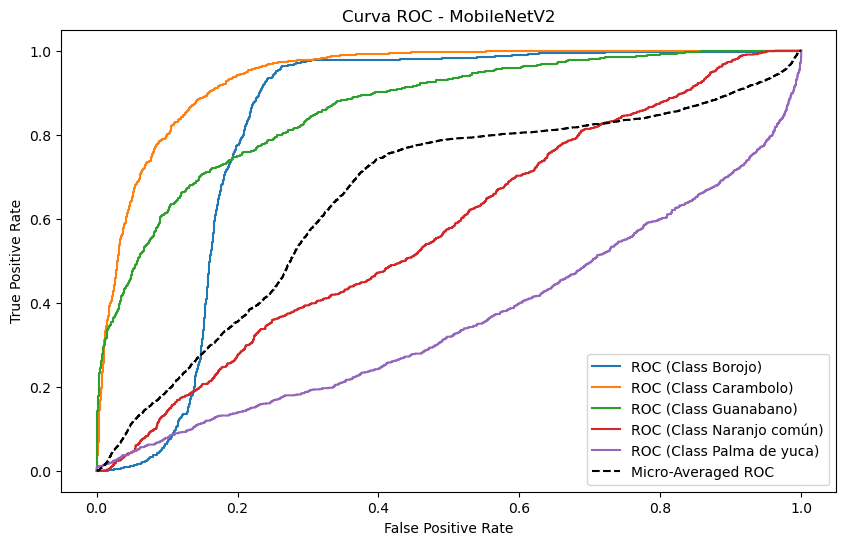

In [14]:
# -------------------
# Modelo: MobileNetV2
# -------------------
modelo_mobilenetv2.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
prob_predictions_mobilenetv2 = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in test_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = modelo_mobilenetv2(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        prob_predictions_mobilenetv2.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Obtener las etiquetas reales (y_true) de los datos de prueba
y_true_mobilenetv2 = true_labels_val

# Convertir la lista a un array de numpy
prob_predictions_mobilenetv2 = np.array(prob_predictions_mobilenetv2)

# Calcular la curva ROC y el AUC para cada clase y modelo
fpr_mobilenetv2 = dict()
tpr_mobilenetv2 = dict()
roc_auc_mobilenetv2 = dict()

for i in range(num_classes):
    fpr_mobilenetv2[i], tpr_mobilenetv2[i], _ = roc_curve(y_true_mobilenetv2, prob_predictions_mobilenetv2[:, i], pos_label=i)
    roc_auc_mobilenetv2[i] = auc(fpr_mobilenetv2[i], tpr_mobilenetv2[i])

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_mobilenetv2)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_mobilenetv2)
tprs.append(tpr_mobilenetv2)
roc_aucs.append(roc_auc_mobilenetv2)

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc_mobilenetv2.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_mobilenetv2[i], tpr_mobilenetv2[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(prob_predictions_mobilenetv2).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - MobileNetV2')
plt.legend()
#plt.xscale('log')
#plt.xlim([0.0, 0.5])  
#plt.ylim([0.99, 1.0]) 
plt.show()

Macro-AUC: 0.7007
Micro-AUC: 0.6444


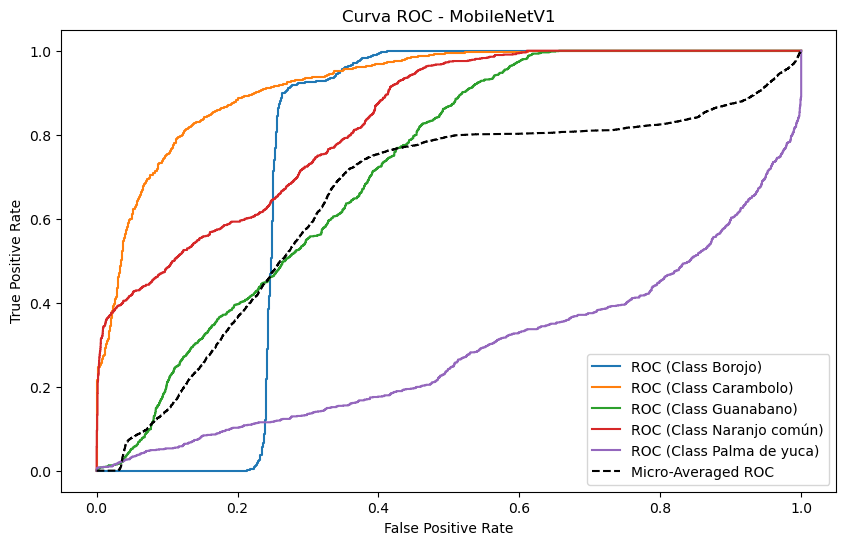

In [15]:
# -------------------
# Modelo: MobileNetV1
# -------------------
modelo_mobilenetv1.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
prob_predictions_mobilenetv1 = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in test_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = modelo_mobilenetv1(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        prob_predictions_mobilenetv1.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Obtener las etiquetas reales (y_true) de los datos de prueba
y_true_mobilenetv1 = true_labels_val

# Convertir la lista a un array de numpy
prob_predictions_mobilenetv1 = np.array(prob_predictions_mobilenetv1)

# Calcular la curva ROC y el AUC para cada clase y modelo
fpr_mobilenetv1 = dict()
tpr_mobilenetv1 = dict()
roc_auc_mobilenetv1 = dict()

for i in range(num_classes):
    fpr_mobilenetv1[i], tpr_mobilenetv1[i], _ = roc_curve(y_true_mobilenetv1, prob_predictions_mobilenetv1[:, i], pos_label=i)
    roc_auc_mobilenetv1[i] = auc(fpr_mobilenetv1[i], tpr_mobilenetv1[i])

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_mobilenetv1)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_mobilenetv1)
tprs.append(tpr_mobilenetv1)
roc_aucs.append(roc_auc_mobilenetv1)

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc_mobilenetv1.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_mobilenetv1[i], tpr_mobilenetv1[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(prob_predictions_mobilenetv1).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - MobileNetV1')
plt.legend()
#plt.xscale('log')
#plt.xlim([0.0, 0.5])  
#plt.ylim([0.96, 1.0]) 
plt.show()


Macro-AUC: 0.8099
Micro-AUC: 0.7163


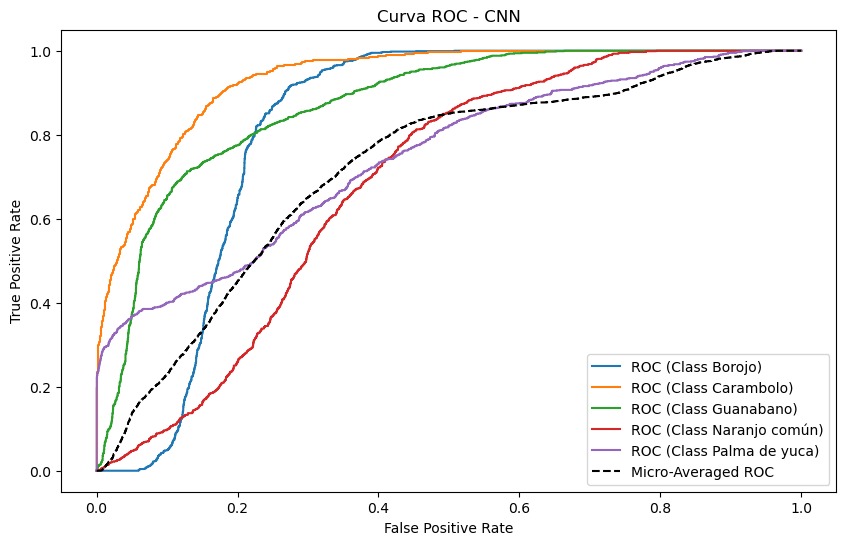

In [16]:
# -------------------
# Modelo: CNN
# -------------------
modelo_cnn.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
prob_predictions_cnn = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in test_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = modelo_cnn(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        prob_predictions_cnn.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Obtener las etiquetas reales (y_true) de los datos de prueba
y_true_cnn = true_labels_val

# Convertir la lista a un array de numpy
prob_predictions_cnn = np.array(prob_predictions_cnn)

# Calcular la curva ROC y el AUC para cada clase y modelo
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()

for i in range(num_classes):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_true_cnn, prob_predictions_cnn[:, i], pos_label=i)
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_cnn)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_cnn)
tprs.append(tpr_cnn)
roc_aucs.append(roc_auc_cnn)

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc_cnn.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_cnn[i], tpr_cnn[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(prob_predictions_cnn).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - CNN')
plt.legend()
#plt.xscale('log')
#plt.xlim([0.0, 0.5])  
#plt.ylim([0.8, 1.0]) 
plt.show()


Macro-AUC: 0.9993
Micro-AUC: 0.9856


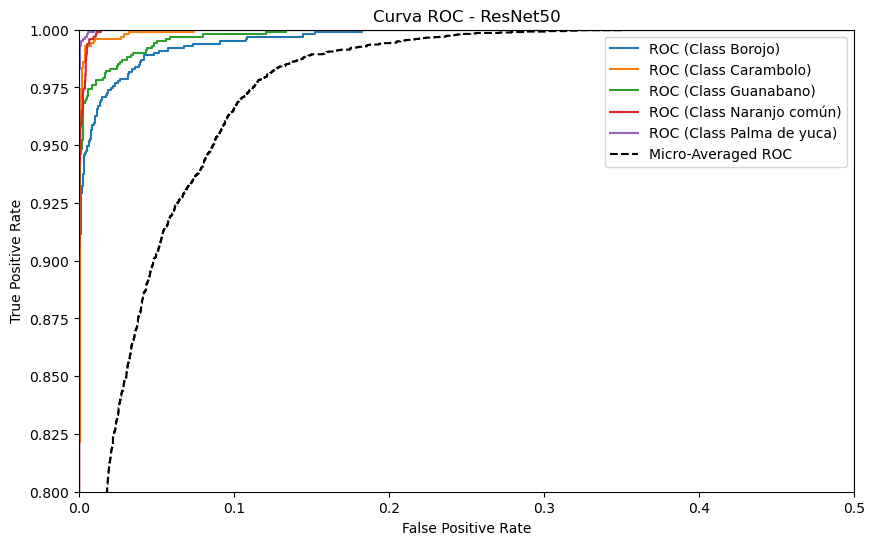

In [28]:
# -------------------
# Modelo: r50
# -------------------
modelo_r50.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
prob_predictions_r50 = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in test_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = modelo_r50(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        prob_predictions_r50.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Obtener las etiquetas reales (y_true) de los datos de prueba
y_true_r50 = true_labels_val

# Convertir la lista a un array de numpy
prob_predictions_r50 = np.array(prob_predictions_r50)

# Calcular la curva ROC y el AUC para cada clase y modelo
fpr_r50 = dict()
tpr_r50 = dict()
roc_auc_r50 = dict()

for i in range(num_classes):
    fpr_r50[i], tpr_r50[i], _ = roc_curve(y_true_r50, prob_predictions_r50[:, i], pos_label=i)
    roc_auc_r50[i] = auc(fpr_r50[i], tpr_r50[i])

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_r50)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_r50)
tprs.append(tpr_r50)
roc_aucs.append(roc_auc_r50)

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc_r50.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_r50[i], tpr_r50[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(prob_predictions_r50).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - ResNet50')
plt.legend()
#plt.xscale('log')
plt.xlim([0.0, 0.5])  
plt.ylim([0.8, 1.0]) 
plt.show()


Macro-AUC: 0.9997
Micro-AUC: 0.9998


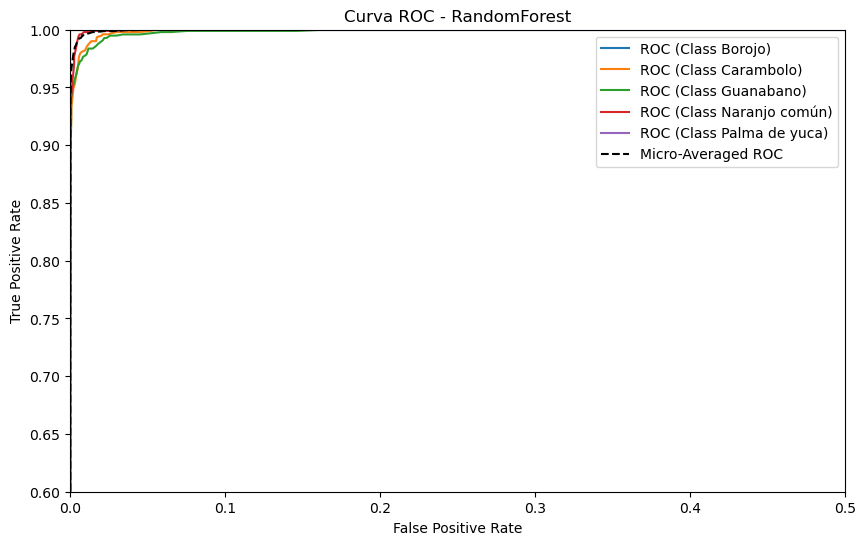

In [18]:
# -------------------
# Modelo: RANDOMFOREST
# -------------------
# Obtener las probabilidades de predicción en lugar de las clases
predicted_scores_val_rf = modelo_randomforest.predict_proba(val_features)

# Binarizar las etiquetas verdaderas
true_labels_val_bin = label_binarize(val_labels, classes=range(num_classes))

# Inicializar variables para almacenar la tasa de falsos positivos, la tasa de verdaderos positivos y el AUC
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

# Calcular la curva ROC para cada clase y el AUC
for i in range(num_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(true_labels_val_bin[:, i], predicted_scores_val_rf[:, i])
    roc_auc_rf[class_names[i]] = auc(fpr_rf[i], tpr_rf[i])
    #print(f'AUC (Class {class_names[i]}): {roc_auc_rf[class_names[i]]:.4f}')

# Calcular el macro-promedio del AUC
roc_auc_macro_rf = np.mean(list(roc_auc_rf.values()))
print(f'Macro-AUC: {roc_auc_macro_rf:.4f}')

# Calcular el micro-AUC
fpr_micro_rf, tpr_micro_rf, _ = roc_curve(true_labels_val_bin.ravel(), predicted_scores_val_rf.ravel())
roc_auc_micro_rf = auc(fpr_micro_rf, tpr_micro_rf)
print(f'Micro-AUC: {roc_auc_micro_rf:.4f}')

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_rf)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_rf)
tprs.append(tpr_rf)
roc_aucs.append(roc_auc_rf)

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'ROC (Class {class_names[i]})')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro_rf, tpr_micro_rf, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - RandomForest')
plt.legend()
plt.xlim([0.0, 0.5])  
plt.ylim([0.6, 1.0])
plt.show()


## Métricas 'classification report' Y matriz confusión
1. *Precision (Precisión)*:
   - Precision se refiere a la proporción de instancias positivas predichas correctamente con respecto a todas las instancias positivas predichas (verdaderos positivos más falsos positivos).
   - Precision mide la exactitud de las predicciones positivas del modelo.
   - De las instancias que el modelo predijo como positivas, ¿cuántas eran realmente positivas?
2. *Recall (Recuperación o Sensibilidad)*:
   - Recall se refiere a la proporción de instancias positivas predichas correctamente con respecto a todas las instancias positivas reales (verdaderos positivos más falsos negativos).
   - Recall mide la capacidad del modelo para capturar todas las instancias positivas.
   - De todas las instancias positivas reales, ¿cuántas pudo capturar el modelo?
3. *F1-Score*:
   - F1-Score es la media armónica de Precision y Recall. Proporciona un equilibrio entre Precision y Recall, siendo especialmente útil cuando hay un desequilibrio en las clases.
4. *Matriz de Confusión*:
   - La Matriz de Confusión es una tabla que muestra la cantidad de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN).

Reporte de Clasificación:
               precision    recall  f1-score   support

       Borojo       1.00      1.00      1.00       994
    Carambolo       0.97      0.99      0.98      1008
    Guanabano       0.99      0.97      0.98       981
Naranjo común       0.98      0.97      0.98       990
Palma de yuca       1.00      1.00      1.00      1014

     accuracy                           0.99      4987
    macro avg       0.99      0.99      0.99      4987
 weighted avg       0.99      0.99      0.99      4987



<Figure size 1000x1000 with 0 Axes>

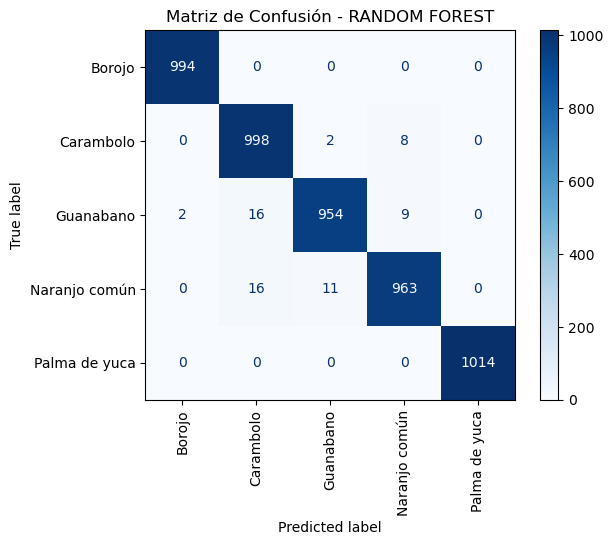

In [27]:
#RF
# Evaluar el modelo RandomForest en el conjunto de validación
predicted_labels_val_rf = modelo_randomforest.predict(val_features)

# Calcular la matriz de confusión
conf_matrix_rf = confusion_matrix(val_labels, predicted_labels_val_rf) #

# Generar y mostrar el classification_report
reporte_clasificacion = classification_report(val_labels, predicted_labels_val_rf,target_names=class_names)
print("Reporte de Clasificación:")
print(reporte_clasificacion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - RANDOM FOREST')
plt.show()

Reporte de Clasificación en el conjunto de validación:
               precision    recall  f1-score   support

       Borojo       0.20      0.24      0.21       993
    Carambolo       1.00      0.04      0.07      1013
    Guanabano       0.30      0.38      0.33      1007
Naranjo común       0.34      0.85      0.48       978
Palma de yuca       0.00      0.00      0.00       997

     accuracy                           0.30      4988
    macro avg       0.37      0.30      0.22      4988
 weighted avg       0.37      0.30      0.22      4988


Matriz de Confusión:
[[235   0 624 134   0]
 [  0  36 114 863   0]
 [  0   0 383 624   0]
 [  0   0 142 836   0]
 [964   0  17  16   0]]


C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

<Figure size 1000x1000 with 0 Axes>

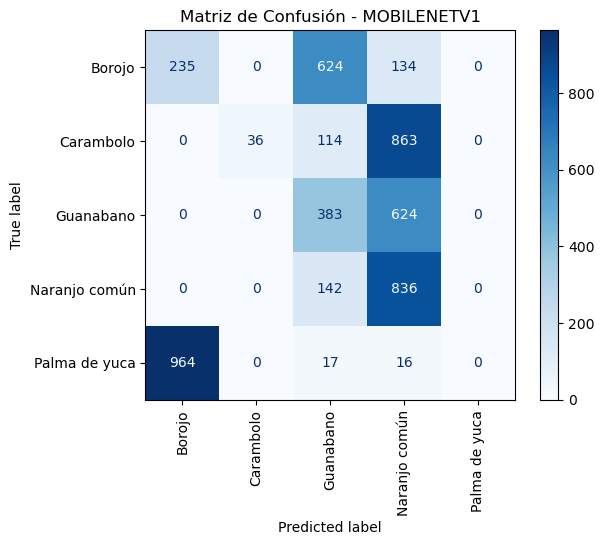

In [20]:
#MOBILENETV1
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_mobilenetv1.to(device)

# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_labels_val = []

# Evaluar el modelo en el conjunto de validación
modelo_mobilenetv1.eval()
with torch.no_grad():
    for inputs_val, labels_val in test_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = modelo_mobilenetv1(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_val, predicted_labels_val,target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir el classification_report
print("Reporte de Clasificación en el conjunto de validación:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(matriz_confusion, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - MOBILENETV1')
plt.show()

Reporte de Clasificación en el conjunto de validación:
               precision    recall  f1-score   support

       Borojo       0.14      0.05      0.08       993
    Carambolo       0.88      0.11      0.19      1013
    Guanabano       0.55      0.68      0.61      1007
Naranjo común       0.22      0.73      0.34       978
Palma de yuca       0.00      0.00      0.00       997

     accuracy                           0.31      4988
    macro avg       0.36      0.31      0.24      4988
 weighted avg       0.36      0.31      0.24      4988


Matriz de Confusión:
[[ 53   0 218 722   0]
 [  0 109  74 830   0]
 [  0  14 683 310   0]
 [  0   1 266 711   0]
 [326   0   0 671   0]]


C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

<Figure size 1000x1000 with 0 Axes>

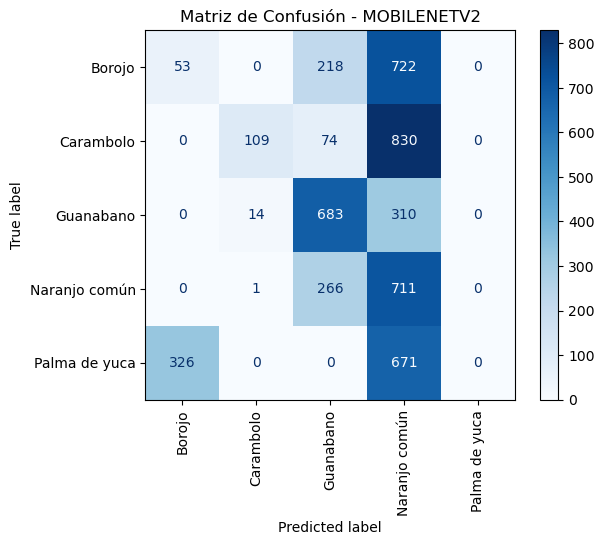

In [21]:
#MOBILENETV2
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_mobilenetv2.to(device)

# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_labels_val = []

# Evaluar el modelo en el conjunto de validación
modelo_mobilenetv2.eval()
with torch.no_grad():
    for inputs_val, labels_val in test_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = modelo_mobilenetv2(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_val, predicted_labels_val,target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir el classification_report
print("Reporte de Clasificación en el conjunto de validación:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(matriz_confusion, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - MOBILENETV2')
plt.show()

Reporte de Clasificación en el conjunto de validación:
               precision    recall  f1-score   support

       Borojo       0.36      0.35      0.36       993
    Carambolo       1.00      0.05      0.09      1013
    Guanabano       0.38      0.91      0.53      1007
Naranjo común       0.27      0.41      0.33       978
Palma de yuca       1.00      0.06      0.10       997

     accuracy                           0.36      4988
    macro avg       0.60      0.36      0.28      4988
 weighted avg       0.60      0.36      0.28      4988


Matriz de Confusión:
[[351   0 626  16   0]
 [  7  49 113 844   0]
 [  0   0 916  91   0]
 [  4   0 569 405   0]
 [600   0 214 128  55]]


<Figure size 1000x1000 with 0 Axes>

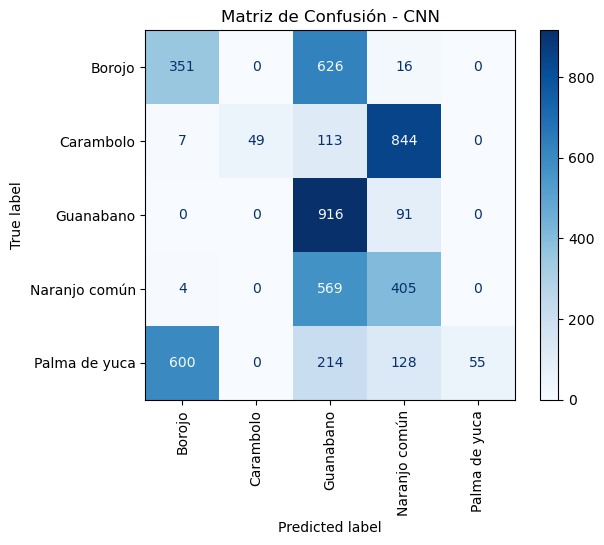

In [22]:
#CNN
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_cnn.to(device)

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    true_labels_val = []
    predicted_labels_val = []

    for inputs_val, labels_val in test_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = modelo_cnn(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_val, predicted_labels_val,target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir el classification_report
print("Reporte de Clasificación en el conjunto de validación:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(matriz_confusion, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - CNN')
plt.show()

## Pruebas análisis y overfit
EL modelo escogido Resnet 50 mostró señales de overfit y se realizaron entrenamientos supervisados para disminuir el recall. Dando como resultado las siguientes métricas

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_r50 = resnet50(weights=None)

# Modificar la capa de salida para adaptarla a 5 clases
num_ftrs = modelo_r50.fc.in_features
modelo_r50.fc = nn.Linear(num_ftrs, 5)  # 5 clases en tu conjunto de datos

# Cargar los pesos guardados en el modelo
modelo_r50.load_state_dict(torch.load(modelo_resnet50_best))
modelo_r50 = modelo_r50.to(device)
modelo_r50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Inicializar listas para almacenar los resultados
fprs = []
tprs = []
roc_aucs = []

# Almacenar AUCs para cada modelo
model_aucs = []
model_names = ['MobileNetV1', 'MobileNetV2', 'SimpleCNN','Modelo ResNet50']
#models = [modelo_mobilenetv1, modelo_mobilenetv2, modelo_cnn,modelo_r50]
num_classes = 5

Macro-AUC: 0.8497
Micro-AUC: 0.7329


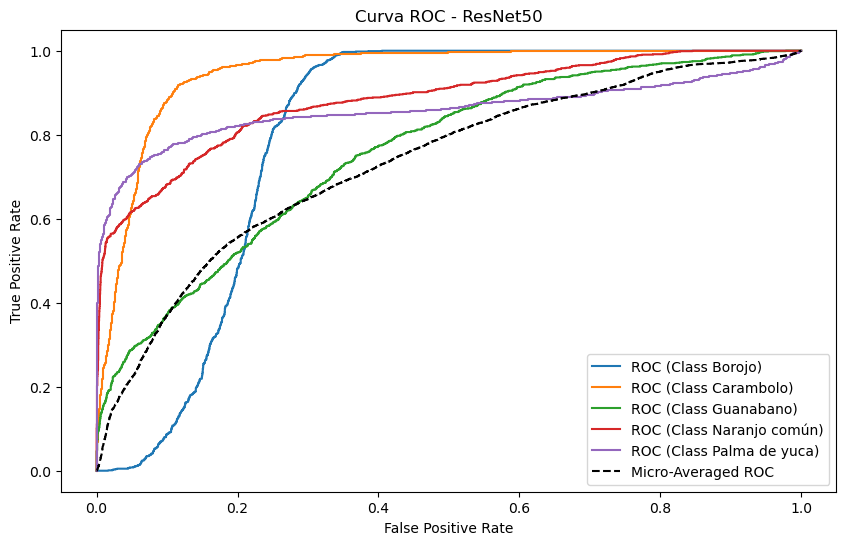

In [25]:
# -------------------
# Modelo: r50
# -------------------
modelo_r50.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
prob_predictions_r50 = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in test_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = modelo_r50(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        prob_predictions_r50.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Obtener las etiquetas reales (y_true) de los datos de prueba
y_true_r50 = true_labels_val

# Convertir la lista a un array de numpy
prob_predictions_r50 = np.array(prob_predictions_r50)

# Calcular la curva ROC y el AUC para cada clase y modelo
fpr_r50 = dict()
tpr_r50 = dict()
roc_auc_r50 = dict()

for i in range(num_classes):
    fpr_r50[i], tpr_r50[i], _ = roc_curve(y_true_r50, prob_predictions_r50[:, i], pos_label=i)
    roc_auc_r50[i] = auc(fpr_r50[i], tpr_r50[i])

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_r50)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_r50)
tprs.append(tpr_r50)
roc_aucs.append(roc_auc_r50)

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc_r50.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_r50[i], tpr_r50[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(prob_predictions_r50).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - ResNet50')
plt.legend()
#plt.xscale('log')
#plt.xlim([0.0, 0.5])  
#plt.ylim([0.9995, 1.0]) 
plt.show()


Reporte de Clasificación en el conjunto de validación:
               precision    recall  f1-score   support

       Borojo       0.73      0.99      0.84       993
    Carambolo       0.99      0.97      0.98      1013
    Guanabano       1.00      0.79      0.88      1007
Naranjo común       0.76      1.00      0.86       978
Palma de yuca       1.00      0.56      0.72       997

     accuracy                           0.86      4988
    macro avg       0.90      0.86      0.86      4988
 weighted avg       0.90      0.86      0.86      4988


Matriz de Confusión:
[[987   0   0   6   0]
 [  0 983   0  30   0]
 [ 35   8 797 167   0]
 [  0   0   0 978   0]
 [338   0   0 104 555]]


<Figure size 1000x1000 with 0 Axes>

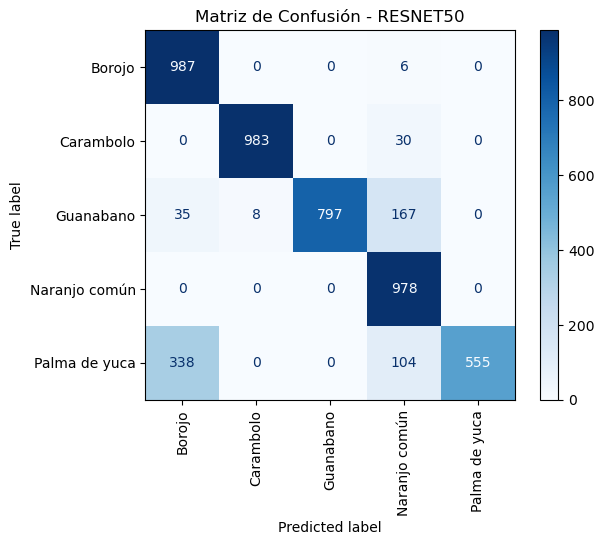

In [23]:
#RESNET50
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_r50.to(device)

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    true_labels_val = []
    predicted_labels_val = []

    for inputs_val, labels_val in test_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = modelo_r50(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_val, predicted_labels_val, target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir el classification_report y la matriz de confusión
print("Reporte de Clasificación en el conjunto de validación:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(matriz_confusion, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - RESNET50')
plt.show()

### Historial de pruebas en distintos puntos del entrenamiento
contiene base de como se comportaban modelos con test_loader

C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Reporte de Clasificación en el conjunto de validación:
               precision    recall  f1-score   support

       Borojo       0.72      0.65      0.68       100
    Carambolo       0.33      0.02      0.04       100
    Guanabano       0.30      0.54      0.38       100
Naranjo común       0.09      0.04      0.06       100
Palma de yuca       0.56      1.00      0.72       100

     accuracy                           0.45       500
    macro avg       0.40      0.45      0.38       500
 weighted avg       0.40      0.45      0.38       500


Matriz de Confusión:
[[ 65   0   8  27   0]
 [  0   2  46  13  39]
 [  8   0  54   0  38]
 [ 17   4  75   4   0]
 [  0   0   0   0 100]]


<Figure size 1000x1000 with 0 Axes>

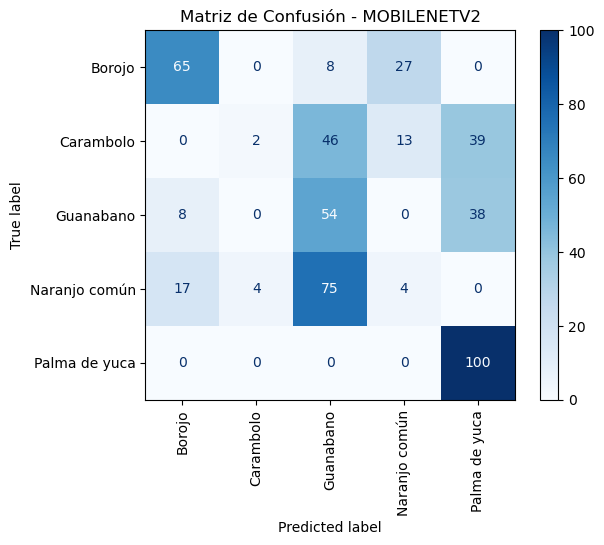

In [44]:
#MOBILENETV2
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_mobilenetv2.to(device)

# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_labels_val = []

# Evaluar el modelo en el conjunto de validación
modelo_mobilenetv2.eval()
with torch.no_grad():
    for inputs_val, labels_val in test_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = modelo_mobilenetv2(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_val, predicted_labels_val,target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir el classification_report
print("Reporte de Clasificación en el conjunto de validación:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(matriz_confusion, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - MOBILENETV2')
plt.show()

Reporte de Clasificación en el conjunto de test:
               precision    recall  f1-score   support

       Borojo       0.83      0.85      0.84       100
    Carambolo       0.32      0.13      0.18       100
    Guanabano       0.32      0.39      0.35       100
Naranjo común       0.00      0.00      0.00       100
Palma de yuca       0.43      1.00      0.60       100

     accuracy                           0.47       500
    macro avg       0.38      0.47      0.40       500
 weighted avg       0.38      0.47      0.40       500


Matriz de Confusión:
[[ 85   0  14   0   1]
 [  0  13   0   4  83]
 [  0  24  39   0  37]
 [ 18   4  68   0  10]
 [  0   0   0   0 100]]


<Figure size 1000x1000 with 0 Axes>

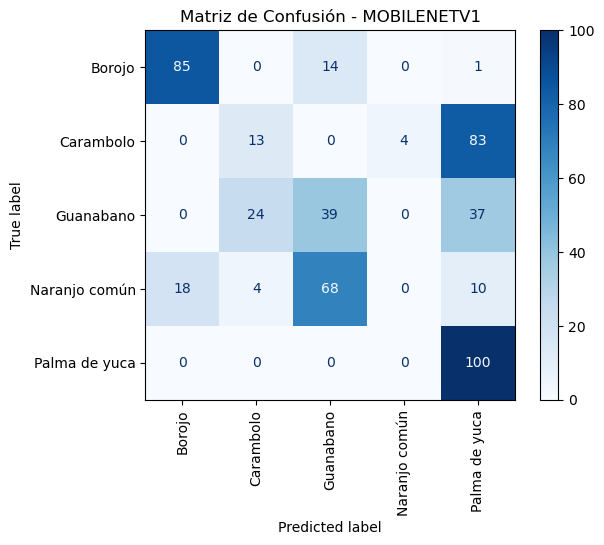

In [42]:
#MOBILENETV1
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_mobilenetv1.to(device)

# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_test = []
predicted_labels_test = []

# Evaluar el modelo en el conjunto de validación
modelo_mobilenetv1.eval()

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)  # Mover datos a la GPU si es necesario
        outputs_test = modelo_mobilenetv1(inputs_test)
        _, predicted_test = torch.max(outputs_test, 1)
        true_labels_test.extend(labels_test.cpu().numpy())
        predicted_labels_test.extend(predicted_test.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_test, predicted_labels_test, target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_test, predicted_labels_test)

# Imprimir el classification_report
print("Reporte de Clasificación en el conjunto de test:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(matriz_confusion, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - MOBILENETV1')
plt.show()


### Pruebas específicas con Resnet50 
Se utilizó un conjunto de datos test_loader2 que contiene imágenes de las hojas en situaciones poco convencionales y difíciles de leer para modelos, esto para encontrar un equilibrio entre los datos test que podrían tener noisy data y afectar el criterio de decisión.

C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Reporte de Clasificación en el conjunto de validación:
               precision    recall  f1-score   support

       Borojo       0.34      0.42      0.38       100
    Carambolo       0.67      0.08      0.14       100
    Guanabano       0.04      0.02      0.03       100
Naranjo común       0.52      0.81      0.63       100
Palma de yuca       0.61      1.00      0.76       100

     accuracy                           0.47       500
    macro avg       0.44      0.47      0.39       500
 weighted avg       0.44      0.47      0.39       500


Matriz de Confusión:
[[ 42   0  32  17   9]
 [ 19   8   8  13  52]
 [ 48   4   2  46   0]
 [ 13   0   3  81   3]
 [  0   0   0   0 100]]


<Figure size 1000x1000 with 0 Axes>

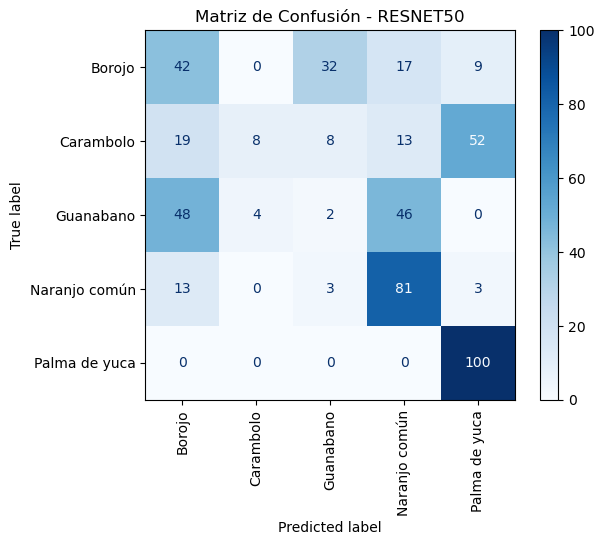

In [24]:
#RESNET50
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_r50.to(device)

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    true_labels_val = []
    predicted_labels_val = []

    for inputs_val, labels_val in test_loader2:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = modelo_r50(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_val, predicted_labels_val, target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir el classification_report y la matriz de confusión
print("Reporte de Clasificación en el conjunto de validación:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(matriz_confusion, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - RESNET50')
plt.show()

C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Macro-AUC: 0.8326
Micro-AUC: 0.8163


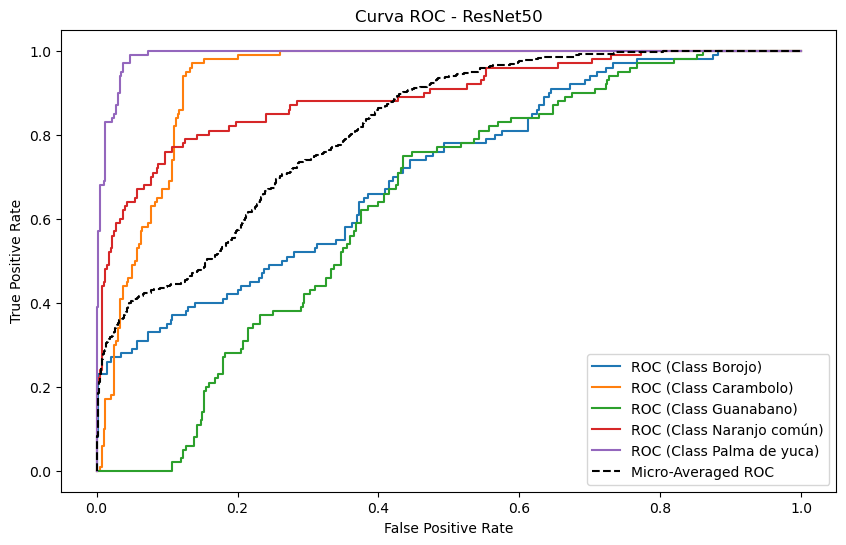

In [25]:
# -------------------
# Modelo: r50
# -------------------
modelo_r50.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
prob_predictions_r50 = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in test_loader2:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = modelo_r50(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        prob_predictions_r50.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Obtener las etiquetas reales (y_true) de los datos de prueba
y_true_r50 = true_labels_val

# Convertir la lista a un array de numpy
prob_predictions_r50 = np.array(prob_predictions_r50)

# Calcular la curva ROC y el AUC para cada clase y modelo
fpr_r50 = dict()
tpr_r50 = dict()
roc_auc_r50 = dict()

for i in range(num_classes):
    fpr_r50[i], tpr_r50[i], _ = roc_curve(y_true_r50, prob_predictions_r50[:, i], pos_label=i)
    roc_auc_r50[i] = auc(fpr_r50[i], tpr_r50[i])

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_r50)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_r50)
tprs.append(tpr_r50)
roc_aucs.append(roc_auc_r50)

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc_r50.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_r50[i], tpr_r50[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(prob_predictions_r50).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - ResNet50')
plt.legend()
#plt.xscale('log')
#plt.xlim([0.0, 0.5])  
#plt.ylim([0.9995, 1.0]) 
plt.show()
